<table align="left">
  <td>
    <a href="https://is.gd/swcO5R" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Codificación de Datos

Al trabajar con datasets es común encontrar características categóricas (nominales u ordinales), que no es posible pasarlas directamente al modelo.

<a href="https://ai-ml-analytics.com/wp-content/uploads/2021/02/Encoding-1.png"><img src="https://ai-ml-analytics.com/wp-content/uploads/2021/02/Encoding-1.png" alt="Tipos de Encoding"  width="400" border="2"></a>


Para este ejemplo se utilizará el dataset que presenta el desempeño de los estudiantes en examenes publicado en [Kaggle](https://www.kaggle.com/datasets/spscientist/students-performance-in-exams). 

References: https://is.gd/LoFv0q

# 1. Importar Librerias

In [45]:
# Data wrangling
import pandas as pd
import numpy as np

# Data visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# 2. Importar y leer el dataset

In [13]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DataScience/Data_Information/StudentsPerformance.csv")
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


#3. Descripción de la Información

El conjunto de datos del rendimiento de los estudiantes en los exámenes en Kaggle consiste en las notas obtenidas por 1.000 estudiantes en las asignaturas de matemáticas, lectura y escritura. Junto con estas puntuaciones de los exámenes, también se incluye en el conjunto de datos la descripción de cada estudiante, como su género, raza/etnia, nivel de educación de los padres, almuerzo y curso de preparación para los exámenes.

El objetivo de este proyecto es construir un modelo de aprendizaje automático que pueda **predecir la puntuación de los estudiantes en los exámenes a partir de su descripción.** Para reiterar, se trata de un problema de regresión en el aprendizaje automático.

#4. Datos perdidos y tipo de datos

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [15]:
data.dtypes.value_counts()

object    5
int64     3
dtype: int64

Tenemos 5 variables categóricas y 3 variables numéricas.

Resulta que todas las variables predictoras son variables categóricas y todas las variables objetivo son variables numéricas.

# 5. Crear una variable Objetivo

Para simplificar, vamos a tomar la media de las 3 puntuaciones de las pruebas, de modo que sólo nos quede una variable objetivo que predecir.

Dado que las 3 puntuaciones de las pruebas están altamente correlacionadas entre sí, es conveniente que tomemos la media.

In [16]:
score = data[['math score', 'reading score', 'writing score']]
score.head()

,math score,reading score,writing score
0,72,72,74
1,69,90,88
2,90,95,93
3,47,57,44
4,76,78,75


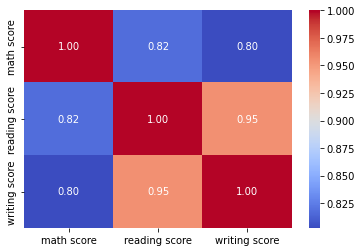

In [17]:
# Correlation between test scores

correlation = score.corr()
sns.heatmap(correlation, annot = True, fmt = '.2f', cmap = 'coolwarm')

In [18]:
# Calculate average of all test results
data['mean score'] = score.mean(axis = 1)

# Drop math score, reading score and writing score
data = data.drop(['math score', 'reading score', 'writing score'], axis = 1)

# Show first 5 rows of new dataframe
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,mean score
0,female,group B,bachelor's degree,standard,none,72.666667
1,female,group C,some college,standard,completed,82.333333
2,female,group B,master's degree,standard,none,92.666667
3,male,group A,associate's degree,free/reduced,none,49.333333
4,male,group C,some college,standard,none,76.333333


In [19]:
# Mean score data type

print("Mean score data type: ", data['mean score'].dtype)

Mean score data type:  float64


# 6. Analisis de datos Exploratorio

El análisis exploratorio de datos es el proceso de análisis y visualización de las variables de un conjunto de datos. Este paso no es necesario para la codificación de características, pero es util analizar los datos antes de realizar cualquier aprendizaje automático. 

## 6.1 Variables predictoras
Las variables predictoras del conjunto de datos son

- Género
- Raza/etnia
- Nivel educativo de los padres
- Almuerzo
- Curso de preparación para el examen

En esta sección, exploraremos cómo estas diferentes características influyen en el resultado de la puntuación de un estudiante en el examen.

### 6.1.1 Gender


In [20]:
# Mean score by gender 

data[['gender', 'mean score']].groupby('gender', as_index = False).mean().sort_values(by = 'mean score', ascending = False, ignore_index = True)

,gender,mean score
0,female,69.569498
1,male,65.837483


Text(0.5, 1.0, 'Mean Score by Gender')

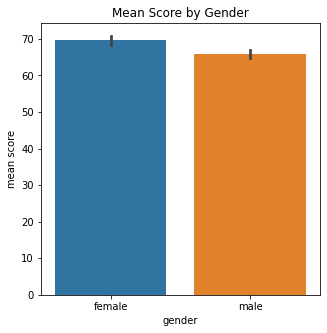

In [21]:
# Mean score by gender barplot

plt.figure(figsize = (5, 5))
sns.barplot(x = 'gender', y = 'mean score', data = data)
plt.title('Mean Score by Gender')

En promedio las alumnas obtienen mejores resultados que los alumnos.

### 6.1.2 Race/ethnicity

In [23]:
# Mean score by race/ethnicity

data[['race/ethnicity', 'mean score']].groupby('race/ethnicity', as_index = False).mean().sort_values(by = 'mean score', ascending = False, ignore_index = True)

,race/ethnicity,mean score
0,group E,72.752381
1,group D,69.179389
2,group C,67.131661
3,group B,65.468421
4,group A,62.992509


Text(0.5, 1.0, 'Mean Score by Race/Ethnicity')

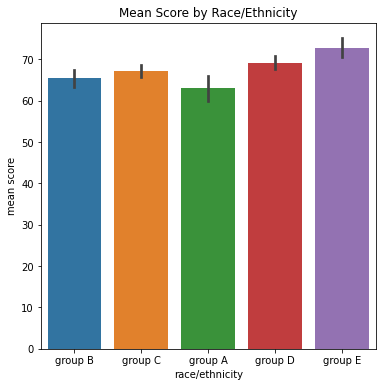

In [24]:
# Mean score by race/ethnicity barplot

plt.figure(figsize = (6, 6))
sns.barplot(x = 'race/ethnicity', y = 'mean score', data = data)
plt.title('Mean Score by Race/Ethnicity')

Parece haber una tendencia creciente en las puntuaciones medias de las pruebas a medida que pasamos del grupo A al grupo E, es decir, los alumnos del grupo A son los que obtienen peores resultados, mientras que los del grupo E son los que obtienen mejores resultados.

Sin embargo, a falta de más información, nos resulta difícil sacar alguna conclusión.

### 6.1.3 Nivel educativo de los padres

In [26]:
# Mean score by parental level of education 

data[['parental level of education', 'mean score']].groupby('parental level of education', as_index = False).mean().sort_values(by = 'mean score', ascending = False, ignore_index = True)

,parental level of education,mean score
0,master's degree,73.598870
1,bachelor's degree,71.923729
2,associate's degree,69.569069
3,some college,68.476401
4,some high school,65.108007
5,high school,63.096939


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

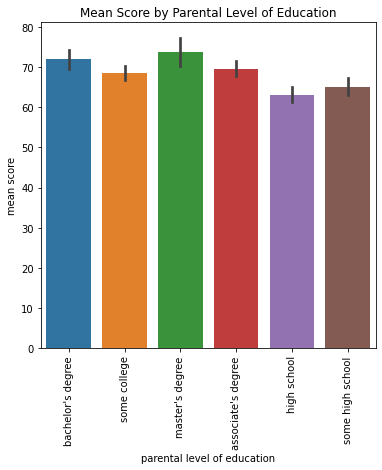

In [27]:
# Mean score by parental level of education barplot

plt.figure(figsize = (6, 6))
sns.barplot(x = 'parental level of education', y = 'mean score', data = data)
plt.title('Mean Score by Parental Level of Education')
plt.xticks(rotation = 90)

En su mayor parte, los resultados coinciden con lo que cabría esperar, es decir, que a medida que aumenta el nivel educativo de los padres, también aumenta la puntuación media en los exámenes.

### 6.1.4 Almuerzo


In [28]:
# Mean score by lunch

data[['lunch', 'mean score']].groupby('lunch', as_index = False).mean().sort_values(by = 'mean score', ascending = False, ignore_index = True)

,lunch,mean score
0,standard,70.837209
1,free/reduced,62.199061


Text(0.5, 1.0, 'Mean Score by Lunch')

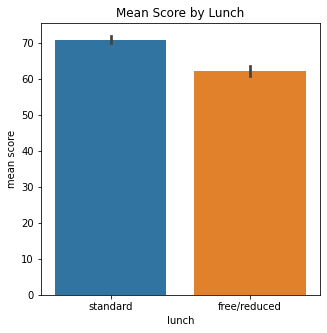

In [29]:
# Mean score by lunch barplot

plt.figure(figsize = (5, 5))
sns.barplot(x = 'lunch', y = 'mean score', data = data)
plt.title('Mean Score by Lunch')

Los estudiantes con almuerzo estándar obtienen mejores resultados que los que tienen almuerzo gratuito/reducido.

El almuerzo puede considerarse un indicador de la situación económica de los alumnos. Por lo tanto, tiene sentido que los estudiantes que tienen una mejor situación económica tengan un mejor rendimiento escolar en comparación con los que tienen una peor situación económica, por término medio.

### 6.1.5 Curso de preparación de exámenes

In [30]:
# Mean score by test preparation course 

data[['test preparation course', 'mean score']].groupby('test preparation course', as_index = False).mean().sort_values(by = 'mean score', ascending = False, ignore_index = True)

,test preparation course,mean score
0,completed,72.669460
1,none,65.038941


Text(0.5, 1.0, 'Mean Score by Test Preparation Course')

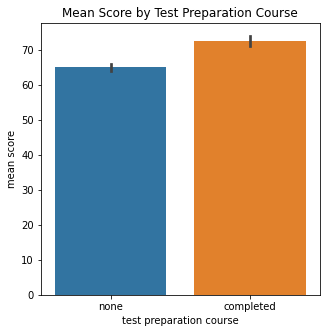

In [31]:
# Mean score by test preparation course barplot

plt.figure(figsize = (5, 5))
sns.barplot(x = 'test preparation course', y = 'mean score', data = data)
plt.title('Mean Score by Test Preparation Course')

Esto no debería sorprender en absoluto. Cuanto más preparados estén los estudiantes para su examen, mejor será su rendimiento.

## 6.2 Target variable (mean score)


In [32]:
# Mean score summary statistics

data['mean score'].describe()

count    1000.000000
mean       67.770667
std        14.257326
min         9.000000
25%        58.333333
50%        68.333333
75%        77.666667
max       100.000000
Name: mean score, dtype: float64

Text(0.5, 1.0, 'Distribution of Mean Score')

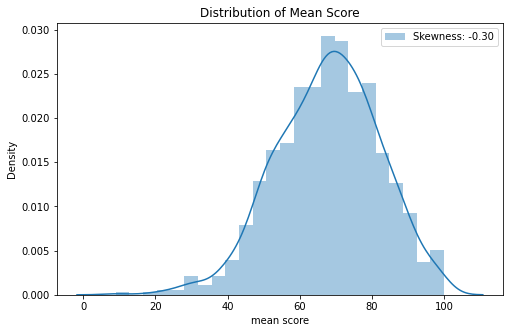

In [33]:
# Distribution of mean score 

plt.figure(figsize = (8, 5))
sns.distplot(data['mean score'], label = 'Skewness: {:.2f}'.format(data['mean score'].skew()))
plt.legend(loc = 'best')
plt.title('Distribution of Mean Score')

# 7. Codificación de características

Ahora que hemos explorado por completo las variables del conjunto de datos, podemos pasar a obtener la lectura del conjunto de datos para su modelización.

Más concretamente, queremos convertir los datos categóricos de nuestro conjunto de datos en datos numéricos. Este proceso se conoce como codificación de características.

Pero antes de sumergirnos en la codificación de características, es importante que primero contrastemos la diferencia entre una variable nominal y una variable ordinal. Esto es para que podamos hacer coincidir el codificador correcto con la variable correcta.

**La variable nominal** es una variable categórica cuyos datos no tienen un orden lógico. Algunos ejemplos de datos nominales son

- Hombre y mujer
- Ubicación A, ubicación B y ubicación C

**La variable ordinal**, por otro lado, también es una variable categórica pero sus datos siguen un orden lógico. Algunos ejemplos de datos ordinales son:

- Pequeño, mediano y grande
- Malo, neutro y bueno
- Niños, adultos y ancianos
- Ingresos bajos, medios y altos

Como veremos en esta sección, las variables nominales se codifican con **OneHotEncoder**, mientras que las ordinales se codifican con **OrdinalEncoder**.

## 7.1 Codificación de las variables nominales

Las variables nominales de nuestro conjunto de datos incluyen:

- Género (Gender)
- Raza/etnia (Race/ethnicity)
- Almuerzo (Lunch)
- Curso de preparación para el examen (Test prepation course)


En esta sección, exploraremos dos formas diferentes de codificar las variables **nominales**, una utilizando el OneHotEncoder de Scikit-learn y la otra utilizando el get_dummies de Pandas.

### 7.1.1 Scikit-learn OneHotEncoder

In [34]:
# Instantiate OneHotEncoder

ohe = OneHotEncoder(sparse = False)

In [35]:
# Apply OneHotEncoder to the gender column 

ohe.fit_transform(data[['gender']])[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]])

In [36]:
# The first 5 rows the gender column for comparison

data['gender'].head()

0    female
1    female
2    female
3      male
4      male
Name: gender, dtype: object

In [37]:
# Gender categories in OneHotEncoder 

ohe.categories_

[array(['female', 'male'], dtype=object)]

Como podemos ver, OneHotEncoder ha creado dos columnas para representar la característica de género en nuestro marco de datos, una para mujeres y otra para hombres.

Las estudiantes recibirán un valor de 1 en la columna de mujeres y 0 en la de hombres, mientras que los estudiantes varones recibirán un valor de 0 en la columna de mujeres y 1 en la de hombres.

Pero lo más importante es que OneHotEncoder ha transformado con éxito lo que originalmente era una variable categórica en una variable numérica.

### 7.1.3 Pandas get_dummies

In [38]:
# Pandas get_dummies approach

pd.get_dummies(data['gender']).head()

,female,male
0,1,0
1,1,0
2,1,0
3,0,1
4,0,1


Aunque ambos enfoques dan el mismo resultado, en general se prefiere OneHotEncoder a get_dummies por las siguientes razones:

- Con OneHotEncoder, nuestro marco de datos original sigue teniendo el mismo tamaño y, por tanto, es más fácil de gestionar y explorar.

- OneHotEncoder puede incorporarse como parte de un pipeline en Scikit-learn mientras que get_dummies requiere un enfoque más manual para la codificación.

- Esto hace que OneHotEncoder sea más eficiente a la hora de transformar tanto el conjunto de entrenamiento como el conjunto de prueba.

- Con OneHotEncoder, podemos utilizar GridSearch para evaluar y elegir los parámetros de preprocesamiento.

- Las puntuaciones de validación cruzada (Cross-validation scores) son más fiables con OneHotEncoder que con get_dummies.

Más adelante exploraremos la idea de construir un pipeline de aprendizaje automático.

## 7.2 Codificación de la variable ordinal

La única variable ordinal en nuestro conjunto de datos es la característica del **nivel de educación de los padres**.

En esta sección, consideraremos de nuevo dos enfoques para codificar la variable ordinal, uno utilizando Scikit-learn OrdinalEncoder mientras que el otro utilizando el método de mapa de Pandas.

### 7.2.1 OrdinalEncoder de Scikit-learn
OrdinalEncoder se diferencia de OneHotEncoder en que asigna valores incrementales a valores únicos en una variable ordinal en lugar de sólo 0 y 1.

Esto ayuda a los modelos de aprendizaje automático a reconocer una variable ordinal y a utilizar posteriormente la información que ha aprendido para hacer predicciones más precisas.

Veamos ahora cómo podemos codificar la característica nivel de educación de los padres utilizando OrdinalEncoder.

In [39]:
# Unique values in the parental level of education column

list(data['parental level of education'].unique())

["bachelor's degree",
 'some college',
 "master's degree",
 "associate's degree",
 'high school',
 'some high school']

Es importante que especifiquemos el orden de una variable ordinal. Para nuestra característica de nivel de educación de los padres, queremos que el orden sea el siguiente:

- Some high school
- High school
- Some college
- Associate's degree
- Bachelor's degree
- Master's degree

In [40]:
# Specify the order for the level of education 

education_categories = ['some high school', 'high school', 'some college', "associate's degree", "bachelor's degree", "master's degree"]

In [41]:
# Instantiate ordinal encoder

oe = OrdinalEncoder(categories = [education_categories])

In [42]:
# Apply ordinal encoder to parental level of education column

oe.fit_transform(data[['parental level of education']])[:5]

array([[4.],
       [2.],
       [5.],
       [3.],
       [2.]])

In [43]:
# First 5 rows of parental level of education for comparison 

data['parental level of education'].head()

0     bachelor's degree
1          some college
2       master's degree
3    associate's degree
4          some college
Name: parental level of education, dtype: object

Obsérvese que **OrdinalEncoder** ha asignado el valor 0 a alguna escuela secundaria, 1 a la escuela superior, 2 a alguna universidad, 3 al grado de asociado, 4 a la licenciatura y, por último, 5 a la maestría.

### 7.2.2 Método del mapa de Pandas
El método de mapa de Pandas es un enfoque más manual para la codificación de variables ordinales. Aunque replica el resultado del OrdinalEncoder, no es ideal para codificar variables ordinales con un alto número de valores únicos.

In [44]:
# Pandas map method 

data['parental level of education'].map({'some high school': 0, 
                                         'high school': 1,
                                         'some college': 2,
                                         "associate's degree": 3, 
                                         "bachelor's degree": 4,
                                         "master's degree": 5}).head()

0    4
1    2
2    5
3    3
4    2
Name: parental level of education, dtype: int64

## 7.3 Hacer transformador de columnas (column transformer)

Para el resto de este colab, sólo consideraremos OneHotEncoder y OrdinalEncoder como medios para codificar las variables categóricas en nuestro conjunto de datos.

En esta sección, combinaremos OneHotEncoder y OrdinalEncoder en un transformador de columna de un solo paso.

In [46]:
# Get predictor variables and target variable from data

X = data.drop('mean score', axis = 1)
Y = data['mean score']

In [47]:
# Make column transformer which consists of OneHotEncoder and OrdincalEncoder

column_transform = make_column_transformer(
    (ohe, ['gender', 'race/ethnicity', 'lunch', 'test preparation course']), 
    (oe, ['parental level of education']))

In [48]:
# Apply column transformer to predictor variables 

column_transform.fit_transform(X)[:5]

array([[1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 4.],
       [1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 2.],
       [1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 5.],
       [0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 3.],
       [0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 2.]])

# 8. Construir una cadena (pipeline) de aprendizaje automático
Una cadena de aprendizaje automático encadena varios pasos en el proceso de aprendizaje automático en el que el resultado de cada paso se utiliza como entrada para el siguiente. Normalmente se utiliza para encadenar los procedimientos de preprocesamiento de datos junto con el modelado en un flujo de trabajo cohesivo.

En este caso, construiremos dos cadenas que comparten el mismo transformador de columnas que hemos creado anteriormente, pero con un modelo de aprendizaje automático diferente, uno que utiliza la regresión lineal y el otro que utiliza el refuerzo de gradiente.

A continuación, compararemos la precisión de los resultados de la predicción utilizando el error medio absoluto (MAE) y el error medio cuadrático (RMSE). El modelo con un menor error de predicción se considera más preciso que el otro.

In [49]:
# Train test split 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", Y_test.shape)

X_train shape:  (700, 5)
Y_train shape:  (700,)
X_test shape:  (300, 5)
Y_test shape:  (300,)


In [50]:
# Instantiate pipeline with linear regression

lm = LinearRegression()
lm_pipeline = make_pipeline(column_transform, lm)

In [51]:
# Instantiate pipeline with gradient boosting

gbm = GradientBoostingRegressor()
gbm_pipeline = make_pipeline(column_transform, gbm)

In [52]:
# Fit pipeline to training set and make predictions on test set 

lm_pipeline.fit(X_train, Y_train)
lm_predictions = lm_pipeline.predict(X_test)
print("First 5 LM predictions: ", list(lm_predictions[:5]))

gbm_pipeline.fit(X_train, Y_train)
gbm_predictions = gbm_pipeline.predict(X_test)
print("First 5 GBM predictions: ", list(gbm_predictions[:5]))

First 5 LM predictions:  [70.75, 66.25, 71.0625, 56.625, 78.0625]
First 5 GBM predictions:  [70.03246540754012, 72.82747187650256, 68.63467096651152, 58.88811703198365, 76.97875270900471]


In [53]:
# Compare the number of predictions with the size of test set

print("Number of LM predictions: ", len(lm_predictions))
print("Number of GBM predictions: ", len(gbm_predictions))
print("Size of test set: ", len(Y_test))

Number of LM predictions:  300
Number of GBM predictions:  300
Size of test set:  300


El número de predicciones coincide con el tamaño del conjunto de pruebas. Ahora podemos proceder a evaluar la precisión de cada modelo.


In [54]:
# Calculate mean square error and root mean squared error 

lm_mae = mean_absolute_error(lm_predictions, Y_test)
lm_rmse =  np.sqrt(mean_squared_error(lm_predictions, Y_test))
print("LM MAE: {:.2f}".format(round(lm_mae, 2)))
print("LM RMSE: {:.2f}".format(round(lm_rmse, 2)))

gbm_mae = mean_absolute_error(gbm_predictions, Y_test)
gbm_rmse =  np.sqrt(mean_squared_error(gbm_predictions, Y_test))
print("GBM MAE: {:.2f}".format(round(gbm_mae, 2)))
print("GBM RMSE: {:.2f}".format(round(gbm_rmse, 2)))

LM MAE: 10.48
LM RMSE: 13.13
GBM MAE: 10.95
GBM RMSE: 13.78


Podemos concluir que la regresión lineal es ligeramente más precisa que el gradient boosting.

# 9. Conclusión
En resumen, en este colab hemos aprendido la diferencia entre una variable nominal y una variable ordinal, así como la forma de codificarlas correctamente utilizando Scikit-learn OneHotEncoder y LabelEncoder.

También hemos analizado las ventajas de realizar la codificación de características utilizando la biblioteca Scikit-learn en lugar de la biblioteca Pandas, es decir, la flexibilidad para encadenar el preprocesamiento de datos junto con un modelo de aprendizaje automático para formar un conducto de aprendizaje automático cohesivo.

Por último, comparamos la precisión de dos líneas de trabajo distintas, una con regresión lineal y otra con gradient boosting, para predecir la puntuación media del estudiante en el examen. 

Llegamos a la conclusión de que la regresión lineal es ligeramente más precisa que el refuerzo de gradiente debido al menor error medio absoluto (MAE) y al error medio cuadrático (RMSE).